# Week 6 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to instead using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents) according to all patterns of covariation among their features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [1]:
#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.feature_extraction.text
import sklearn.decomposition
from sklearn import preprocessing, linear_model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.datasets import fetch_20newsgroups, make_blobs
from sklearn.feature_extraction.text import TfidfVectorizer  #Feature extraction
from sklearn.naive_bayes import MultinomialNB #Our learner.
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn import neighbors

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
from matplotlib.colors import ListedColormap
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

%matplotlib inline

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We also develop a couple of functions for splitting our text data:

In [2]:
def split_data(data, prob):
    """split data into fractions [prob, 1 - prob]"""
    results = [], []
    for row in data:
        results[0 if random.random() < prob else 1].append(row)
    return results

# The Naïve Bayes Classifier

## Naive Bayes from Scratch

First, let's build a Naive Bayes classifier from scratch to illustrate what's in a classifier. This example is drawn from *Data Science from Scratch* by Joel Grus. 

### Mathematical Preliminaries

Naïve Bayes contains an independence assumption that the probability of features conditional on classification $S$ is equivalent to the product of conditional probabilities associated with each of those features, hence this model's *naïvité*: $P(X_1 = x_1,\dots,X_n = x_n\,|\,S) = P(X_1 = x_1\,|\,S)\times \dots 
    \times P(X_n = x_n\,|\,S)$

To be concrete, let's assume we are building a spam filter. 

Given a vocabulary $w_1,\dots,w_n$, let $X_i$ be the event "message contains" $w_i$." $X_i = x_i, x_i \in \{0,1\}$. 

$S$ is the event "message is spam" and $\neg S$ is the event "message is not spam."

According to Bayes' Theorem: 

$P(S\,|\,X_1 = x_1,\dots, X_n = x_n) = \frac{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)P(S)}{P(X_1 = x_1,\dots, X_n = x_n)} = \frac{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)P(S)}{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)P(S)\, + \,P(X_1 = x_1,\dots, X_n = x_n\,|\,\neg S)P(\neg S)}$

We further assume that we have no knowledge of the prior probability of spam; so $P(S) = P(\neg S) = 0.5$ (this is the principle of indifference)

With this simplification, $P(S\,|\,X_1 = x_1,\dots, X_n = x_n) = \frac{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)}{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)\, +\, P(X_1 = x_1,\dots, X_n = x_n\,|\,\neg S)}$ 

Now we make the Naive Bayes assumption: $P(X_1 = x_1,\dots,X_n = x_n\,|\,S) = P(X_1 = x_1\,|\,S)\times \dots 
    \times P(X_n = x_n\,|\,S)$
    
We can estimate $P(X_i = x_i\,|\,S)$ by computing the fraction of spam messages containing the word $i$, e.g., Obamacare. 

Smoothing: $P(X_i\,|\,S) = \frac{(k + \textrm{number of spams containing}\, w_i)}{(2k + \textrm{number of spams})}$



### Now, to code this up...

Lets start with spam detection, we have data from: https://spamassassin.apache.org/publiccorpus/ in `data/Spam_Data` with the spam in `data/Spam_Data/spam` and the non spam in `data/Spam_Data/not_spam`

In [3]:
def loadEmailDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into useable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    # regex for stripping out the leading "Subject:" and any spaces after it
    subject_regex = re.compile(r"^Subject:\s+")
    
    #The dict that will become the DataFrame
    emailDict = {
        'category' : [],
        'text' : [],
    }
    for fPath in filePaths:
        with open(fPath, errors='surrogateescape') as f:
            for line in f:
                if line.startswith("Subject:"):
                    #Could also save the subject field
                    subject = subject_regex.sub("", line).strip()
                    emailDict['text'].append(subject)
    emailDict['category'] = [category] * len(emailDict['text'])
    return pandas.DataFrame(emailDict)

spamDF = loadEmailDir('data/Spam_Data/spam', 'spam')
spamDF = spamDF.append(loadEmailDir('data/Spam_Data/not_spam', 'not spam'), ignore_index= True)
spamDF['is_spam'] = [c == 'spam' for c in spamDF['category']]
spamDF[:10]

,category,text,is_spam
0,spam,Life Insurance - Why Pay More?,True
1,spam,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,True
2,spam,Guaranteed to lose 10-12 lbs in 30 days ...,True
3,spam,Re: Fw: User Name & Password to Membership To ...,True
4,spam,[ILUG-Social] re: Guaranteed to lose 10-12 lbs...,True
5,spam,RE: Your Bank Account Information,True
6,spam,"FORTUNE 500 COMPANY HIRING, AT HOME REPS.",True
7,spam,Is Your Family Protected?,True
8,spam,RE: Important Information Concerning Your Bank...,True
9,spam,MULTIPLY YOUR CUSTOMER BASE!,True


We can now tokenize and normalize like normal

In [4]:
def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None, vocab = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
        
    #We will return a list with the stopwords removed
    if vocab is not None:
        vocab_str = '|'.join(vocab)
        workingIter = (w for w in workingIter if re.match(vocab_str, w))
    
    return list(workingIter)

stop_words_nltk = nltk.corpus.stopwords.words('english')
snowball = nltk.stem.snowball.SnowballStemmer('english')

spamDF['tokenized_emails'] = spamDF['text'].apply(lambda x: nltk.word_tokenize(x))
spamDF['normalized_emails'] = spamDF['tokenized_emails'].apply(lambda x: normlizeTokens(x, stopwordLst = None, stemmer = None))
spamDF[:5]

,category,text,is_spam,tokenized_emails,normalized_emails
0,spam,Life Insurance - Why Pay More?,True,"[Life, Insurance, -, Why, Pay, More, ?]","[life, insurance, why, pay, more]"
1,spam,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,True,"[[, ILUG, ], Guaranteed, to, lose, 10-12, lbs,...","[ilug, guaranteed, to, lose, lbs, in, days]"
2,spam,Guaranteed to lose 10-12 lbs in 30 days ...,True,"[Guaranteed, to, lose, 10-12, lbs, in, 30, day...","[guaranteed, to, lose, lbs, in, days]"
3,spam,Re: Fw: User Name & Password to Membership To ...,True,"[Re, :, Fw, :, User, Name, &, Password, to, Me...","[re, fw, user, name, password, to, membership,..."
4,spam,[ILUG-Social] re: Guaranteed to lose 10-12 lbs...,True,"[[, ILUG-Social, ], re, :, Guaranteed, to, los...","[re, guaranteed, to, lose, lbs, in, days]"


Now we need to count the number of times each word shows up in spam and non-spam

In [5]:
def count_words(traingDF, textColumn, trainingColumn):
    counts = collections.defaultdict(lambda: [0, 0])
    for index, row in traingDF.iterrows():
        for word in set(row[textColumn]):
            if row[trainingColumn]:
                counts[word][0] += 1
            else:
                counts[word][1] += 1
    return counts
wordCounts = count_words(spamDF, 'normalized_emails', 'is_spam')
wordCounts['cancel']

[0, 2]

We need a function to convert these counts into (smoothed) probabilities

In [6]:
def word_probabilities(counts, total_spams, total_non_spams, k=0.5):
    """turn the word_counts into a list of triplets 
    w, p(w | spam) and p(w | ~spam)"""
    retTuples = []
    for w, (spam, non_spam) in counts.items():
        retTuples.append((w,
             (spam + k) / (total_spams + 2 * k),
             (non_spam + k) / (total_non_spams + 2 * k)))
    return retTuples

Now we need to come up with a way to compute the spam probability for a message, given word probabilities. With the Naive Bayes assumption, we *would* be multiplying together a bunch of probabilities. This is bad (e.g., floating point underflow) so we instead compute:

$p_1 *\dots*p_n = \exp(\, \log(p_1) + \dots + \log(p_n)\,)$; recall $\log(ab) = \log a + \log b$ and $\exp(\, \log x \,) = x$

Thank you, John Napier (1550-1617), for inventing logs.

In [7]:
def spam_probability(word_probs, message_words):
    #message_words = tokenize(message)
    log_prob_if_spam = log_prob_if_not_spam = 0.0 #Initialize; we are working with log probs to deal with underflow.

    for word, prob_if_spam, prob_if_not_spam in word_probs: #We iterate over all possible words we've observed
        # for each word in the message, 
        # add the log probability of seeing it 
        if word in message_words:
            log_prob_if_spam += math.log(prob_if_spam) #This is prob of seeing word if spam
            log_prob_if_not_spam += math.log(prob_if_not_spam) #This is prob of seeing word if not spam

        # for each word that's not in the message
        # add the log probability of _not_ seeing it
        else:
            log_prob_if_spam += math.log(1.0 - prob_if_spam)
            log_prob_if_not_spam += math.log(1.0 - prob_if_not_spam)
    P = 1/(1 + math.exp(log_prob_if_not_spam - log_prob_if_spam))
    #prob_if_spam = math.exp(log_prob_if_spam) #Compute numerator
    #prob_if_not_spam = math.exp(log_prob_if_not_spam)
    #return prob_if_spam / (prob_if_spam + prob_if_not_spam) #Compute whole thing and return
    return P

Think: how would this change if $P(S) \neq P(\neg S)$

Now we write a class (this is a Python term) for our Naive Bayes Classifier

In [8]:
class NaiveBayesClassifier:

    def __init__(self, k=0.5):
        self.k = k
        self.word_probs = [] #Initializes word_probs as an empty list, sets a default smoothing parameters

    def train(self, training_set, trainingColumn, textColumn): #Operates on the training_set
    
        # count spam and non-spam messages: first step of training
        num_spams = training_set[trainingColumn].value_counts()[True]
        num_non_spams = len(training_set) - num_spams
        
        # run training data through our "pipeline"
        word_counts = count_words(training_set, textColumn, trainingColumn)
        self.word_probs = word_probabilities(word_counts, 
                                             num_spams, 
                                             num_non_spams,
                                             self.k) #"Train" classifier 
                                             
    def classify(self, message):
        return spam_probability(self.word_probs, message) #Now we have all we need to classify a message


To train and then evaluate our model, we will split our data into ***training*** & ***testing*** sets.

In [9]:
np.random.seed(0)
shuffledSpamDF = spamDF.reindex(np.random.permutation(spamDF.index))
holdBackFraction = .2
holdBackIndex = int(holdBackFraction * len(shuffledSpamDF))
train_data = shuffledSpamDF[holdBackIndex:].copy()
test_data = shuffledSpamDF[:holdBackIndex].copy()

In [10]:
classifier = NaiveBayesClassifier()

In [11]:
classifier.train(train_data, 'is_spam', 'normalized_emails')

In [12]:
len(train_data)

2739

In [13]:
train_data[:5]

,category,text,is_spam,tokenized_emails,normalized_emails
685,not spam,CNET: A note to our subscribers,False,"[CNET, :, A, note, to, our, subscribers]","[cnet, a, note, to, our, subscribers]"
2971,not spam,New Blog Category: Yahoo,False,"[New, Blog, Category, :, Yahoo]","[new, blog, category, yahoo]"
2720,not spam,[Spambayes] Current histograms,False,"[[, Spambayes, ], Current, histograms]","[spambayes, current, histograms]"
1728,not spam,Re: So I missed this one...,False,"[Re, :, So, I, missed, this, one, ...]","[re, so, i, missed, this, one]"
3135,not spam,Man's leg is found 7 miles from a hit and run ...,False,"[Man, 's, leg, is, found, 7, miles, from, a, h...","[man, leg, is, found, miles, from, a, hit, and..."


Some simple evaluation:

In [14]:
# triplets (subject, actual is_spam, predicted spam probability)
classified = [(row['category'], classifier.classify(row['normalized_emails']))
              for index, row in test_data.iterrows()]

# assume that spam_probability > 0.5 corresponds to spam prediction # and count the combinations of (actual is_spam, predicted is_spam)
counts = collections.Counter((actual == 'spam', predicted_probability > 0.5)
                     for actual, predicted_probability in classified)

Now, let's see how we did! We will do so by computing the Precision, Recall and F-measure or harmonic mean between Precision and Recall.

In [15]:
counts

Counter({(False, False): 558,
         (False, True): 28,
         (True, False): 32,
         (True, True): 66})

Precision:

In [16]:
precision = counts[(True,True)]/(counts[(False,True)]+counts[(True,True)]) #True positives over all positive predictions
print(precision)

0.7021276595744681


Recall:

In [17]:
recall = counts[(True,True)]/(counts[(True,False)]+counts[(True,True)])#what fraction of positives identified
print(recall)

0.673469387755102


F-measure:

In [18]:
f_measure = 2 * (precision * recall)/(precision + recall)
print (f_measure)

0.6875000000000001


Let's look at how the emails are classified.

In [19]:
test_data['predicted_spam_probability'] = [classifier.classify(d) for d in test_data['normalized_emails']]

In [20]:
test_data[:5]

,category,text,is_spam,tokenized_emails,normalized_emails,predicted_spam_probability
927,not spam,VoIP tip: Troubleshooting voice,False,"[VoIP, tip, :, Troubleshooting, voice]","[voip, tip, troubleshooting, voice]",0.018289
182,spam,Wanna see me get fisted?,True,"[Wan, na, see, me, get, fisted, ?]","[wan, na, see, me, get, fisted]",0.580494
33,spam,Give Away FREE CD's - Earn $5K in 30 Days!,True,"[Give, Away, FREE, CD, 's, -, Earn, $, 5K, in,...","[give, away, free, cd, earn, in, days]",0.993856
1473,not spam,Re: The Big Jump,False,"[Re, :, The, Big, Jump]","[re, the, big, jump]",0.000455
981,not spam,RE: [zzzzteana] Digest Number 2453,False,"[RE, :, [, zzzzteana, ], Digest, Number, 2453]","[re, zzzzteana, digest, number]",0.000060


Now, we calculate the ROC curve, and integrate to get the area under the curve (AUC), or probability mass associated with correct classification.

In [21]:
x, y, _ = sklearn.metrics.roc_curve(test_data['is_spam'], test_data['predicted_spam_probability'])
roc_auc = sklearn.metrics.auc(x,y)

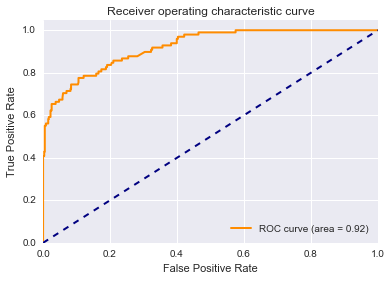

In [22]:
plt.figure()
plt.plot(x,y, color = 'darkorange', lw = 2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

## <span style="color:red">*Your thoughts*</span>

<span style="color:red">What will happen if I change my spam threshold from 0.5?

<span style="color:red">What decision rule are we using, when we assign the class label $\hat{y} = S$ when $P(S\,|\,X_1\dots X_n) = \frac{P(S)\prod_i P(X_i = x_i|S)}{P(\textbf{X})} > 0.5$

<span style="color:red">What will happen if we split the data differently (e.g., less training data, more testing data). 

<span style="color:red">**Try it!**

We can also find words that lead to a high probability of spam (using Bayes' Theorem):

In [23]:
def p_spam_given_word(word_prob):
    """uses bayes's theorem to compute p(spam | message contains word)"""
    # word_prob is one of the triplets produced by word_probabilities

    word, prob_if_spam, prob_if_not_spam = word_prob
    return prob_if_spam / (prob_if_spam + prob_if_not_spam)

In [24]:
words = sorted(classifier.word_probs,key=p_spam_given_word)

In [25]:
spammiest_words = words[-15:]
hammiest_words = words[:15]

In [26]:
spammiest_words

[('extended', 0.01600985221674877, 0.00021413276231263382),
 ('viagra', 0.01600985221674877, 0.00021413276231263382),
 ('hiring', 0.01600985221674877, 0.00021413276231263382),
 ('assistance', 0.01600985221674877, 0.00021413276231263382),
 ('sale', 0.01600985221674877, 0.00021413276231263382),
 ('reps', 0.018472906403940888, 0.00021413276231263382),
 ('per', 0.018472906403940888, 0.00021413276231263382),
 ('clearance', 0.018472906403940888, 0.00021413276231263382),
 ('account', 0.020935960591133004, 0.00021413276231263382),
 ('mortgage', 0.023399014778325122, 0.00021413276231263382),
 ('year', 0.023399014778325122, 0.00021413276231263382),
 ('systemworks', 0.025862068965517241, 0.00021413276231263382),
 ('zzzz', 0.030788177339901478, 0.00021413276231263382),
 ('money', 0.038177339901477834, 0.00021413276231263382),
 ('adv', 0.043103448275862072, 0.00021413276231263382)]

In [27]:
hammiest_words

[('satalk', 0.0012315270935960591, 0.053747323340471095),
 ('spambayes', 0.0012315270935960591, 0.045610278372591004),
 ('zzzzteana', 0.0012315270935960591, 0.031905781584582439),
 ('sadev', 0.0012315270935960591, 0.029764453961456102),
 ('ouch', 0.0012315270935960591, 0.023768736616702354),
 ('perl', 0.0012315270935960591, 0.02291220556745182),
 ('bliss', 0.0012315270935960591, 0.02119914346895075),
 ('selling', 0.0012315270935960591, 0.020770877944325482),
 ('wedded', 0.0012315270935960591, 0.020770877944325482),
 ('problem', 0.0012315270935960591, 0.019057815845824413),
 ('bug', 0.0012315270935960591, 0.01734475374732334),
 ('java', 0.0012315270935960591, 0.01563169164882227),
 ('cvs', 0.0012315270935960591, 0.01563169164882227),
 ('razor', 0.0012315270935960591, 0.014775160599571735),
 ('kiddies', 0.0012315270935960591, 0.014346895074946468)]

# Now with a corpus of Clinton / Obama Press Releases

While the Clinton and Obama Senatorial Press are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [28]:
ObamaClintonReleases = pandas.read_csv("data/ObamaClintonReleases.csv")
ObamaClintonReleases = ObamaClintonReleases.dropna(axis=0, how='any')
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: nltk.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))

Let's turn the 'targetSenator' column into a binary variable.

In [29]:
ObamaClintonReleases['IsObama'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Let's split the data into training data and test data.

In [30]:
np.random.seed(0)
ObamaClintonReleases = ObamaClintonReleases.reindex(np.random.permutation(ObamaClintonReleases.index))
holdBackFraction = .25
holdBackIndex = int(holdBackFraction * len(ObamaClintonReleases))
train_data = ObamaClintonReleases[holdBackIndex:].copy()
test_data = ObamaClintonReleases[:holdBackIndex].copy()

In [31]:
print (len(train_data))
print (len(test_data))

1282
427


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix:

In [32]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data['text'])

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [33]:
TFVects.shape

(1282, 11048)

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization but rather classification and so all principal components are calculated.

In [34]:
PCA = sklearn.decomposition.PCA
pca = PCA().fit(TFVects.toarray())
reduced_data = pca.transform(TFVects.toarray())

Visualization in 2D:

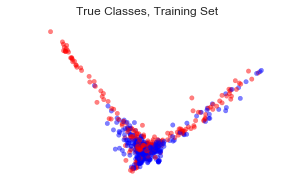

In [35]:
colordict = {
True: 'red',
False: 'blue',
    }
colors = [colordict[c] for c in train_data['IsObama']]
fig = plt.figure(figsize = (5,3))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Clinton from Obama very well. Let's perform a screeplot to see how many dimensions we need.

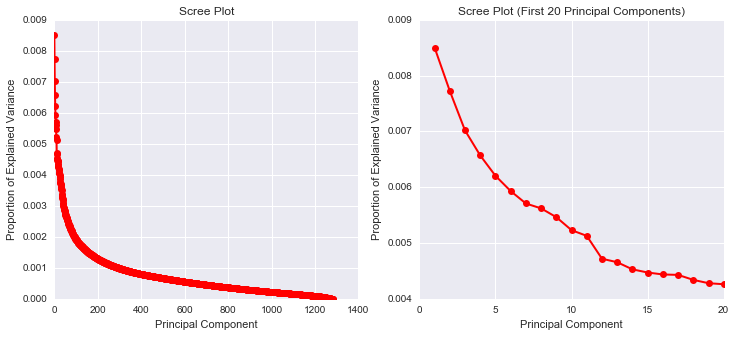

In [36]:
n = TFVects.shape[0]
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=2)
ax1.set_title('Scree Plot')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

ax2 = fig.add_subplot(122)
eigen_vals = np.arange(20) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax2.set_title('Scree Plot (First 20 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')
plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [37]:
X = reduced_data[:, :10]

Transform our predictor variable. 

In [38]:
Y = np.array([int(label) for label in train_data['IsObama']])

Now we fit a logistic regression to our data.

In [39]:
logistic = linear_model.LogisticRegression()
logistic.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's see how the logistic regression performs on the training dataset on we develop the model. Unfortunately, mean accuracy is only about 68%.

In [40]:
logistic.score(X,Y)

0.6840873634945398

How does it perform on the testing dataset, which we "held out" and did not use for model training?

In [41]:
TFVects_test = TFVectorizer.transform(test_data['text'])
reduced_data_test = pca.transform(TFVects_test.toarray())
X_test = reduced_data_test[:, :10]
Y_test = np.array([int(label) for label in test_data['IsObama']])
logistic.score(X_test, Y_test)

0.66042154566744726

Slightly poorer. How about using more dimensions (40)?

In [42]:
X = reduced_data[:, :40]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :40]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

0.737909516381
0.697892271663


Or still more (100)?

In [43]:
X = reduced_data[:, :100]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :100]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

0.833853354134
0.770491803279


Or even more (200)!

In [44]:
X = reduced_data[:, :200]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :200]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

0.879875195008
0.805620608899


This is becoming ridiculous (400)!

In [45]:
X = reduced_data[:, :400]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :400]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

0.91887675507
0.817330210773


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 80%. We can, however, try a logistic regression that uses L1 regularization or the L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [46]:
X = TFVects
logistic_l1= linear_model.LogisticRegression(penalty='l1')
logistic_l1.fit(X, Y)
print(logistic_l1.score(X,Y))

0.851794071763


Train the model using training data, and then test it on the testing data.

In [47]:
print(logistic_l1.score(TFVects_test,Y_test))

0.807962529274


84% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes.

In [48]:
#wc = wordCounts(train_data, 'normalized_text')
wc = count_words(train_data, 'normalized_text', 'IsObama')
wc['veteran']

[70, 43]

In [49]:
classifier = NaiveBayesClassifier()
classifier.train(train_data, 'IsObama', 'normalized_text')

Let's evaluate the result on the test data.

In [50]:
classified = []
for index, row in test_data.iterrows():
    classified.append((row['normalized_text'], row['IsObama'], classifier.classify(row['normalized_text'])))

# assume that spam_probability > 0.5 corresponds to spam prediction # and count the combinations of (actual is_spam, predicted is_spam)
counts = collections.Counter((actual, predicted_probability > 0.5)
                     for text, actual, predicted_probability in classified)

counts

Counter({(False, False): 245,
         (False, True): 1,
         (True, False): 1,
         (True, True): 180})

Precision:

In [51]:
precision = counts[(True,True)]/(counts[(False,True)]+counts[(True,True)]) #True positives over all positive predictions
print(precision)

0.994475138121547


Recall:

In [52]:
recall = counts[(True,True)]/(counts[(True,False)]+counts[(True,True)])#what fraction of positives identified
print(recall)

0.994475138121547


F-measure:

In [53]:
f_measure = 2 * (precision * recall)/(precision + recall)
print (f_measure)

0.994475138121547


In [54]:
df_classification = pandas.DataFrame(classified, columns = ['press release', 'is Obama', 'posterior probability'])
df_classification = df_classification.round(2)

Let's take a look at how well our posterior distribution looks relative to the truth.

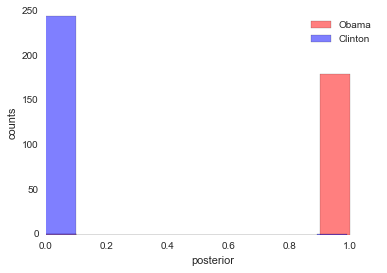

In [55]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.grid(False)
ax1.set_frame_on(False)
df_classification[df_classification['is Obama'] == True]['posterior probability'].hist(alpha = 0.5, ax = ax1, bins = 10, label = 'Obama', color = 'red')
df_classification[df_classification['is Obama'] == False]['posterior probability'].hist(alpha = 0.5, ax = ax1, bins = 10, label = 'Clinton', color = 'blue')
ax1.set_xlim((0,1.1))
ax1.legend()
ax1.set_xlabel('posterior')
ax1.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate.

In [56]:
def p_obama_given_word(word_prob):
    """uses bayes's theorem to compute p(spam | message contains word)"""
    # word_prob is one of the triplets produced by word_probabilities

    word, prob_if_obama, prob_if_not_obama = word_prob
    return prob_if_obama / (prob_if_obama + prob_if_not_obama)

In [57]:
words = sorted(classifier.word_probs,key=p_obama_given_word)

In [58]:
Obama_words = words[-15:]
Clinton_words = words[:15]

What are the words that distinguish Obama and Clinton press releases?

In [59]:
Obama_words

[('opinion', 0.35066162570888471, 0.0059602649006622521),
 ('ethic', 0.042533081285444231, 0.00066225165562913907),
 ('obama', 0.99716446124763702, 0.011258278145695364),
 ('mulka', 0.070888468809073721, 0.00066225165562913907),
 ('christina', 0.074669187145557661, 0.00066225165562913907),
 ('sdb', 0.087901701323251424, 0.00066225165562913907),
 ('barack', 0.99716446124763702, 0.0072847682119205302),
 ('gibb', 0.29395085066162568, 0.0019867549668874172),
 ('brundag', 0.15028355387523629, 0.00066225165562913907),
 ('labolt', 0.18241965973534971, 0.00066225165562913907),
 ('julian', 0.22400756143667297, 0.00066225165562913907),
 ('ortiz', 0.2712665406427221, 0.00066225165562913907),
 ('vietor', 0.32797731568998112, 0.00066225165562913907),
 ('tommi', 0.32797731568998112, 0.00066225165562913907),
 ('newslett', 0.33742911153119093, 0.00066225165562913907)]

In [60]:
Clinton_words

[('yorker', 0.00094517958412098301, 0.147682119205298),
 ('click', 0.00094517958412098301, 0.064238410596026488),
 ('buffalo', 0.00094517958412098301, 0.062913907284768214),
 ('rodham', 0.016068052930056712, 0.93576158940397347),
 ('manhattan', 0.00094517958412098301, 0.054966887417218543),
 ('tourist', 0.00094517958412098301, 0.052317880794701989),
 ('upstat', 0.00094517958412098301, 0.049668874172185427),
 ('albani', 0.00094517958412098301, 0.049668874172185427),
 ('niagara', 0.00094517958412098301, 0.047019867549668873),
 ('westchest', 0.00094517958412098301, 0.043046357615894038),
 ('hudson', 0.00094517958412098301, 0.037748344370860928),
 ('suffolk', 0.00094517958412098301, 0.036423841059602648),
 ('tourism', 0.00094517958412098301, 0.032450331125827812),
 ('syracus', 0.00094517958412098301, 0.032450331125827812),
 ('queen', 0.00094517958412098301, 0.031125827814569535)]

## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [61]:
data = fetch_20newsgroups(data_home = 'data') #Free data to play with: documents from a newsgroup corpus.
data.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

This dataset has a built in breakdown into training and testing sets. We can pick specific categories, and pull the relevant training and testing sets. 

In [62]:
categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course
train = fetch_20newsgroups(subset='train', categories=categories, data_home = 'data')
test = fetch_20newsgroups(subset='test', categories=categories, data_home = 'data')

In [63]:
train['target']

array([2, 2, 1, ..., 2, 3, 1])

In [64]:
len(train.data) #See how many training examples

2153

In [65]:
len(test.data) #Ditto for testing -- it's about 60% training, 40% testing

1432

In [66]:
print(train.data[5]) #Look at an example
#print(train.target_names[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document but rarely across documents in the corpus (more distinctive). 

We also take advantage of a useful feature of Scikit-Learn: we can make pipelines...

In [67]:
model = make_pipeline(TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2'), MultinomialNB()) #This applies the vectorizer, then trains Multinomial NB

In [68]:
model.fit(train.data,train.target) #Training syntax: feed the fit method the training data and the training targets

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=100, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...   vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [69]:
labels = model.predict(test.data)

In [70]:
labels.size

1432

We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding.

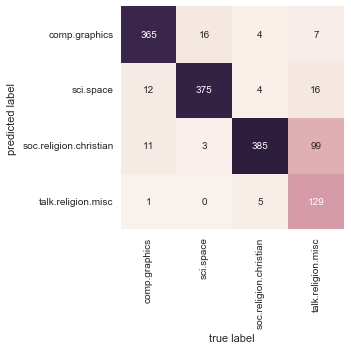

In [71]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Let's calculate the precision, recall, and F-measures.

In [72]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.888801643276
0.875698324022
0.867534845252


Get the ROC curves.
First, we need to binarize the labels.

In [73]:
lb = preprocessing.LabelBinarizer()
lb.fit(test.target)
print(lb.classes_)
print(lb.transform([1, 3]))

[0 1 2 3]
[[0 1 0 0]
 [0 0 0 1]]


In [74]:
y_test = lb.transform(test.target)
y_score = model.predict_proba(test.data)

In [75]:
n_classes = 4

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = sklearn.metrics.auc(fpr["micro"], tpr["micro"])

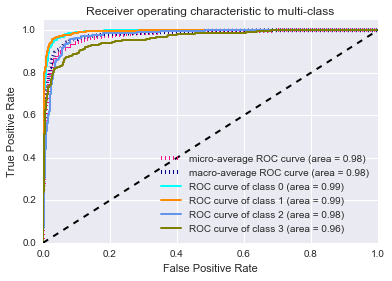

In [76]:
lw = 2
n_classes = 4
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += sp.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] =  sklearn.metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'olive']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

We can also give the model a string and use the predict method to see if it can assign it to a category. Using our model to extend to new, uncoded data might be the primary purpose of a social science application.

In [77]:
def predict_category(s, train=train, model=model): #We just define a simple function here
    return train.target_names[model.predict([s])]

In [78]:
#predict_category('rockets')

Try it yourself with your own strings!


## Now let's add Bernie Sanders to our Obama / Clinton face-off

In [79]:
ObamaClintonSandersReleases = pandas.read_csv("data/ObamaClintonSandersReleases.csv")
ObamaClintonSandersReleases = ObamaClintonSandersReleases.dropna(axis=0, how='any')

Let's split the data into training data and test data.

In [80]:
data = list(zip(ObamaClintonSandersReleases['text'], ObamaClintonSandersReleases['targetSenator']))
random.seed(0) #This is important for replicability
train_data,test_data = split_data(data,0.75)

In [81]:
print (len(train_data))
print (len(test_data))

1476
507


In [82]:
train.data = [data[0] for data in train_data]
train.target = [data[1] for data in train_data]
test.data = [data[0] for data in test_data]
test.target = [data[1] for data in test_data]

In [83]:
model.fit(train.data,train.target) #Training syntax: feed the fit method the training data and the training targets

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=100, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...   vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [84]:
labels = model.predict(test.data)

In [85]:
labels.size

507

In [86]:
model.classes_

array(['Clinton', 'Obama', 'Sanders'], 
      dtype='<U7')

Confusion matrix:

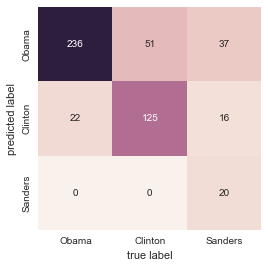

In [87]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Obama', 'Clinton', 'Sanders'], yticklabels=['Obama', 'Clinton', 'Sanders'])
plt.xlabel('true label')
plt.ylabel('predicted label');

Let's get the precision, recall, and F-measure.

In [88]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.780858483391
0.751479289941
0.730628152246


In order to get the ROC curves, first we need to binarize the labels.

In [89]:
lb = preprocessing.LabelBinarizer()
lb.fit(test.target)
print(lb.classes_)
print(lb.transform(['Clinton', 'Obama']))

['Clinton' 'Obama' 'Sanders']
[[1 0 0]
 [0 1 0]]


In [90]:
y_test = lb.transform(test.target)
y_score = model.predict_proba(test.data)

In [91]:
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = sklearn.metrics.auc(fpr["micro"], tpr["micro"])

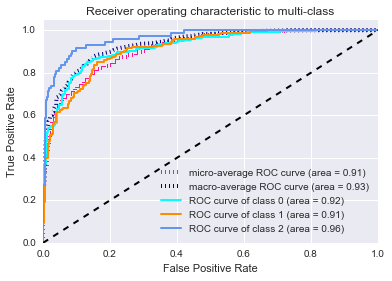

In [92]:
n_classes = 3
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += sp.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] =  sklearn.metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

We can also give the model a string and use the predict method assign it to a category. This extrapolation to new, untagged data will likely be the main point of a social science application.

In [93]:
model.predict(['money'])

array(['Clinton'], 
      dtype='<U7')

In [94]:
model.predict(['Wall Street'])

array(['Clinton'], 
      dtype='<U7')

In [95]:
model.predict(['Chicago'])

array(['Obama'], 
      dtype='<U7')

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.

# Decision Trees

We now return to the python Machine learning package, Scikit-Learn, for a decision tree example. Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

To illustrate how these work, we first create some artificial data to learn:

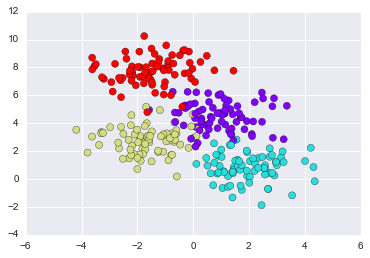

In [96]:
X, y = make_blobs(n_samples=300, centers=4,
                random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [97]:
tree = DecisionTreeClassifier(max_depth=4,random_state=0).fit(X,y)

To see what's going on visually with the classification, we can use this (complex) visualizer. 

In [98]:
def visualize_classifier(model, X, y, Xmod, ymod, ax=None, cmap='rainbow'): #X and y are plotted; Xmod and ymod train
    ax = ax or plt.gca()
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # fit the estimator
    model.fit(Xmod, ymod)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)
    ax.set(xlim=xlim, ylim=ylim)

In [99]:
Xnew, ynew = make_blobs(n_samples=1000, centers=4,
                random_state=0, cluster_std=1.0)

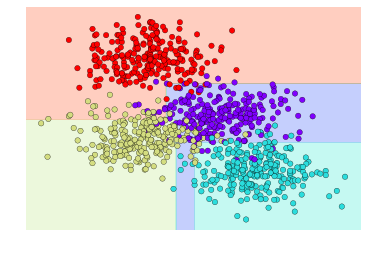

In [100]:
visualize_classifier(DecisionTreeClassifier(max_depth=4,random_state=0), Xnew, ynew, X, y) #We train on the full data

In [101]:
accuracy_score(ynew,DecisionTreeClassifier(max_depth=10,random_state=0).fit(X,y).predict(Xnew))

0.91400000000000003

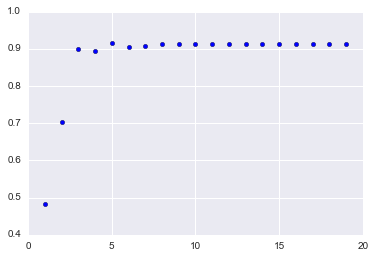

In [102]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = DecisionTreeClassifier(max_depth=i,random_state=0).fit(X,y)
    score = accuracy_score(ynew,tree2.predict(Xnew))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)

We an select different layers of the tree or "prune" the decision tree. At approximately four layers down the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

In [103]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5,random_state=1) #test_size means a 50/50 split
print(len(X))
print(len(Xtrain))
print(len(Xtest))

300
150
150


With some abuse of notation, we can use the visualizer to plot first a classifier trained on the "training" half of the data.

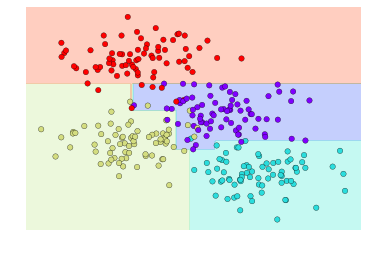

In [104]:
visualize_classifier(DecisionTreeClassifier(max_depth=5,random_state=0), X, y, Xtrain, ytrain) #Train with half the data

Now we can train on the second half of the data--allegedly the test data--to see how different training sets affect the decision boundaries.

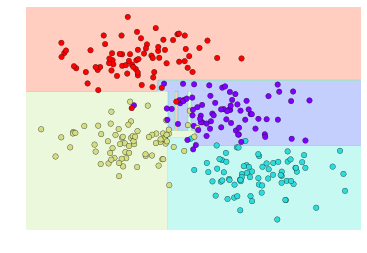

In [105]:
visualize_classifier(DecisionTreeClassifier(random_state=0), X, y, Xtest, ytest) #Train with other half of the data

Finally, we can get a sense of the performance by training on the training data, but PLOTTING the test data

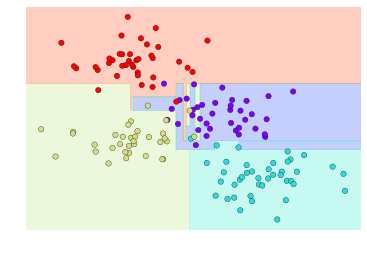

In [106]:
visualize_classifier(DecisionTreeClassifier(), Xtest, ytest, Xtrain, ytrain) #Trains with train data, plots test data

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [107]:
tree = DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [108]:
#?BaggingClassifier #Learn more

In [109]:
bag.fit(X,y) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [110]:
Xnew, ynew = make_blobs(n_samples=10000, centers=4,
                random_state=0, cluster_std=1.0)

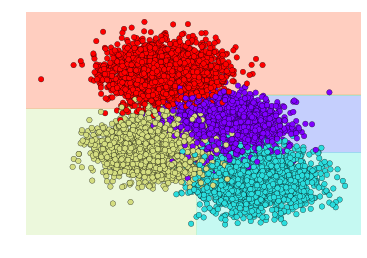

In [111]:
visualize_classifier(bag,Xnew,ynew,X,y) #And visualize
#Remember we can give the full data as training data, as bag automatically splits and trains

In [112]:
recall_score(ynew,bag.predict(Xnew),average='weighted')

0.9204

## Let's try this on the Clinton / Obama / Sanders dataset.

In [113]:
TFVects = TFVectorizer.fit_transform(train.data)

In [114]:
tree = DecisionTreeClassifier(max_depth=4,random_state=0).fit(TFVects,train.target)

In [115]:
TFVects_test = TFVectorizer.transform(test.data)

In [116]:
labels = tree.predict(TFVects_test)

Confusion matrix:

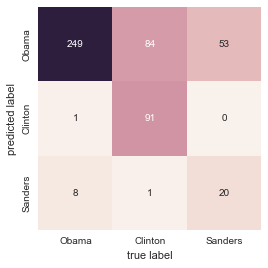

In [117]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Obama', 'Clinton', 'Sanders'], yticklabels=['Obama', 'Clinton', 'Sanders'])
plt.xlabel('true label')
plt.ylabel('predicted label');

The precision, recall, and F-measure.

In [118]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.770930642843
0.710059171598
0.685718256036


The decision tree is not substantially better than Multinomial Naive Bayes. Let's try a random forest.

In [119]:
bag.fit(TFVects,train.target) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [120]:
labels = bag.predict(TFVects_test)

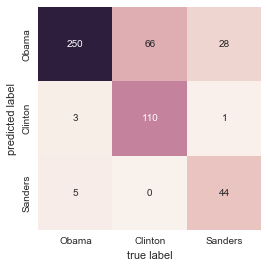

In [121]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Obama', 'Clinton', 'Sanders'], yticklabels=['Obama', 'Clinton', 'Sanders'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [122]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.834074125861
0.79684418146
0.789859355759


The performance is better!

## A Brief Aside -- Random forest regression

First, let's create a challenging, hypothetical dataset. While we may never see this in content analysis, we may see cyclical phenomena like we sketch here.

In [123]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200) #200 uniformly distributed random numbers between 0 and 10
def model(x, sigma=0.3): 
    fast_oscillation = np.sin(5 * x) 
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x)) #Create 200 random numbers, normally distributed

    return slow_oscillation + fast_oscillation + noise

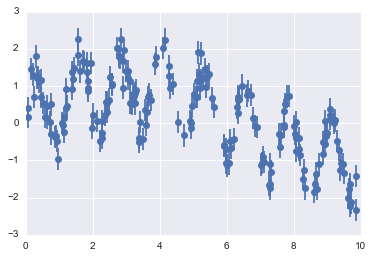

In [124]:
y = model(x)
plt.errorbar(x, y, 0.3, fmt='o'); #Shows one std around point
#plt.scatter(x, y); #Plots the actual points

First we will try to learn this with something simple; a single decision tree, but one that is a regressor, not a classifier.

In [125]:
# Fit regression models
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor(max_depth=10)
regr_1.fit(x[:,None], y)
regr_2.fit(x[:,None], y)
regr_3.fit(x[:,None], y)

# Predict
xfit = np.linspace(0, 10, 1000)
yfit_1 = regr_1.predict(xfit[:, None]) #xfit[:,None] is a work-around to pass a 1d feature matrix
yfit_2 = regr_2.predict(xfit[:, None])
yfit_3 = regr_3.predict(xfit[:, None])

Let's see how these two decision trees do... What do you think will happen as we add depth?

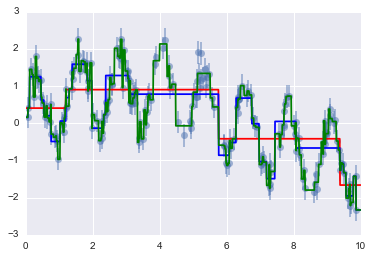

In [126]:
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit_1, '-r'); #depth = 2
plt.plot(xfit,yfit_2,'-b'); #depth = 5
plt.plot(xfit,yfit_3,'-g'); #depth = 10

Or we can use a **random forest regressor**

In [127]:
forest = RandomForestRegressor(200) 
forest.fit(x[:, None], y)
    
yfit = forest.predict(xfit[:, None]) #Predictions of the forest model
ytrue = model(xfit, sigma=0) #This is the underlying data, no noise

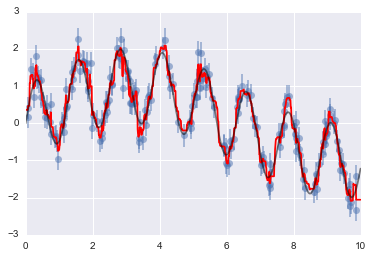

In [128]:
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

This represents a beautiful fit of the underlying pattern. A lot of the noise has been washed out. This exemplifies the power of bagging.

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with the last ***your turn***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the labeled datapoint in question and "borrow" its label.

Let's use newsgroup data again.

In [129]:
categories = ['soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course
train = fetch_20newsgroups(subset='train', categories=categories, data_home = 'data')
test = fetch_20newsgroups(subset='test', categories=categories, data_home = 'data')

Let's visualize it using PCA.

In [130]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train.data)

In [131]:
TFVects.shape

(1776, 11107)

In [132]:
reduced_data = PCA(n_components = 2).fit_transform(TFVects.toarray())

In [133]:
train.target_names

['comp.graphics', 'sci.space', 'soc.religion.christian']

Visualization:

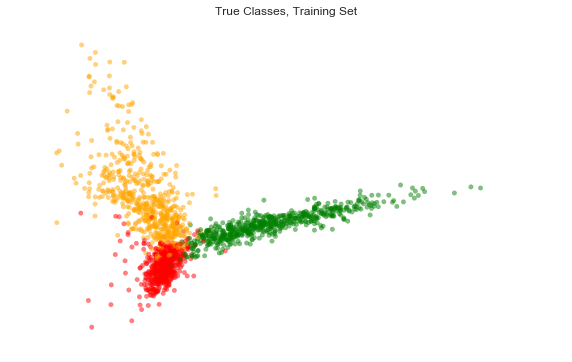

In [134]:
colordict = {
0: 'red',
1: 'orange',
2: 'green',
    }
colors = [colordict[c] for c in train.target]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes, Training Set')
plt.show()

Let's initialize our k-nearest neighbors classifier.

In [135]:
n_neighbors = 15
weights="uniform"
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

For visualization purpopose, let's first try applying the k-nearest neighbors classifier to the projected data.

In [136]:
clf.fit(reduced_data, train.target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [137]:
TFVects_test = TFVectorizer.transform(test.data)
reduced_data_test = PCA(n_components = 2).fit_transform(TFVects_test.toarray())

In [138]:
labels = clf.predict(reduced_data_test)

Confusion matrix:

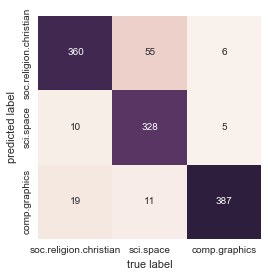

In [139]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label');

The precision, recall, and F-measure.

In [140]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.913440444833
0.910245554615
0.909782484225


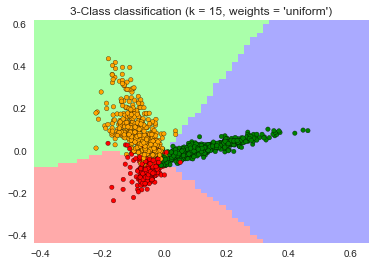

In [141]:
h = .02  # step size in the mesh
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

x_min, x_max = reduced_data[:, 0].min() - 0.2, reduced_data[:, 0].max() + 0.2
y_min, y_max = reduced_data[:, 1].min() - 0.2, reduced_data[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=colors, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = '%s')"
          % (n_neighbors, weights))

plt.show()

Let's use the full tf-idf matrix instead.

In [142]:
clf.fit(TFVects, train.target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [143]:
labels = clf.predict(TFVects_test)

Confusion matrix:

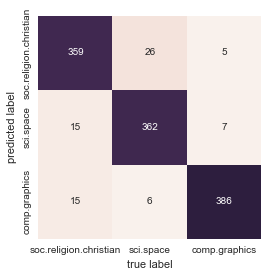

In [144]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label');

Small improvement. In this case, PCA reduced the dimensionality of the data without loosing too much informatin.
Finally, let's use it again on the Obama Clinton Sanders dataset.

In [145]:
train.data = [data[0] for data in train_data]
train.target = [data[1] for data in train_data]
test.data = [data[0] for data in test_data]
test.target = [data[1] for data in test_data]

In [146]:
TFVects_OCS = TFVectorizer.fit_transform(train.data)
TFVects_OCS_test = TFVectorizer.transform(test.data)

In [147]:
clf.fit(TFVects_OCS,train.target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [148]:
labels = clf.predict(TFVects_OCS_test)

Confusion matrix:

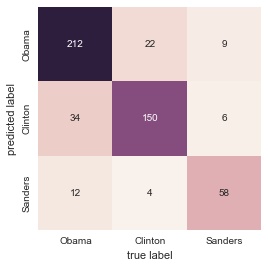

In [149]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Obama', 'Clinton', 'Sanders'], yticklabels=['Obama', 'Clinton', 'Sanders'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [150]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.830867858758
0.828402366864
0.828826514099


## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in week 3?

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the maximum margin between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [151]:
redditDf = pandas.read_csv('data/reddit.csv')

#Drop a couple missing values

redditDf = redditDf.dropna()

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: nltk.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))

We will tf.idf the data to make our vectors

In [152]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['tfVect'] = [np.array(v) for v in redditTFVects.todense()]
redditDf['tfVect'][:5]

0    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.066346072181...
1    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: tfVect, dtype: object

In [153]:
redditDf['tfVect'][0].shape

(1, 6626)

Initilize the model

In [154]:
clf = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Setup a training set

In [155]:
np.random.seed(0)
shuffled_redditDf = redditDf.reindex(np.random.permutation(redditDf.index))
holdBackFraction = .2
holdBackIndex = int(holdBackFraction * len(shuffled_redditDf))
training_redditDf = shuffled_redditDf[holdBackIndex: ].copy()
test_redditDf = shuffled_redditDf[:holdBackIndex].copy()
print(len(training_redditDf))
print(len(test_redditDf))

1279
319


Fit the model

In [156]:
clf.fit(np.stack(training_redditDf['tfVect'], axis=1)[0], training_redditDf['subreddit'].as_matrix())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Here are the 4 classes of posts:

In [157]:
clf.classes_

array(['Bad Roommates: Tales of Irritation', 'Relationships',
       'Tales From Tech Support',
       'Weeaboo Tales: stories about the extreme fans of japanese culture'], dtype=object)

And a prediction from the testing set

In [158]:
#print(clf.predict_proba(test_redditDf['tfVect'][82]))
print(clf.predict(test_redditDf['tfVect'][82]))
print(test_redditDf['subreddit'][82])

['Tales From Tech Support']
Tales From Tech Support


In [159]:
redditDf['svc'] = [clf.predict(v)[0] for v in redditDf['tfVect']]

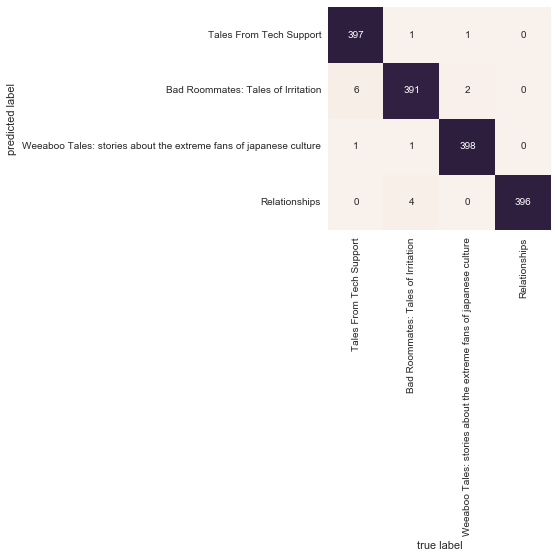

In [160]:
mat = confusion_matrix(redditDf['svc'], redditDf['subreddit'])
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=redditDf['subreddit'].unique(), yticklabels=redditDf['subreddit'].unique())
plt.xlabel('true label')
plt.ylabel('predicted label')

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [161]:
clf = MLPClassifier()
clf

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [162]:
clf.fit(np.stack(training_redditDf['tfVect'], axis=1)[0], training_redditDf['subreddit'].as_matrix())

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [163]:
clf.classes_

array(['Bad Roommates: Tales of Irritation', 'Relationships',
       'Tales From Tech Support',
       'Weeaboo Tales: stories about the extreme fans of japanese culture'], 
      dtype='<U65')

In [164]:
print(clf.predict_proba(test_redditDf['tfVect'][82]))
print(clf.predict(test_redditDf['tfVect'][82]))
print(test_redditDf['subreddit'][82])

[[  1.37361375e-04   1.94214438e-04   9.99477442e-01   1.90982448e-04]]
['Tales From Tech Support']
Tales From Tech Support


In [165]:
test_redditDf['MLP'] = [clf.predict(v)[0] for v in test_redditDf['tfVect']]

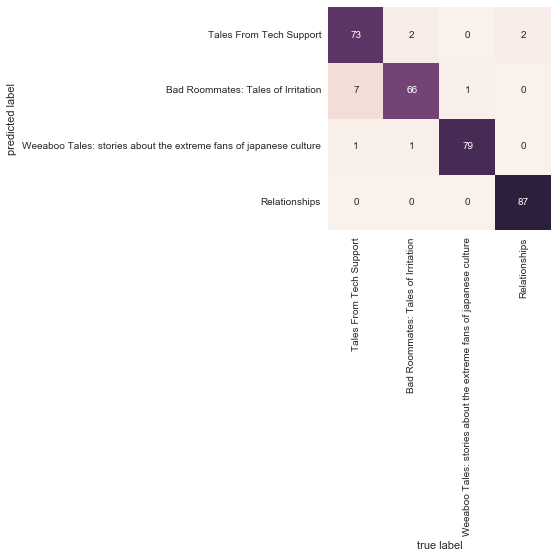

In [166]:
mat = confusion_matrix(test_redditDf['MLP'], test_redditDf['subreddit'])
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=redditDf['subreddit'].unique(), yticklabels=redditDf['subreddit'].unique())
plt.xlabel('true label')
plt.ylabel('predicted label')

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?